In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from wassa.wassa_plots import plot_results_std, plot_SM, plot_colored_raster
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_utils import train_and_plot

In [3]:
date = '2024_12_10'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons3490735590457916
    N_timesteps = 255 # number of timesteps for the raster plot (in ms)
    N_samples = 100 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 4 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 16*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

In [5]:
N_iter = 20
seeds = torch.arange(N_iter)
lambdaz = [0, .0001, .0005, .001, .005, .01, .05, .1]

In [6]:
def performance_as_a_function_of_lambda(world_parameters, training_parameters, date, lambdaz, N_iter = 5, seeds = None, device='cpu'):
    
    results = torch.zeros([3,N_iter,len(lambdaz),6])
    if seeds is not None:
        assert seeds.size(0)==N_iter
    else:
        seeds = torch.randint(1000,[N_iter])
    
    params_mse = training_parameters()
    params_emd = training_parameters()
    params_emd.loss_type = 'emd'
    
    file_name = f'../results/{date}_performance_as_a_function_of_lambda_{world_parameters().get_parameters()}_{params_emd.get_parameters()}_{lambdaz[0]}_{lambdaz[-1]}_{N_iter}'
    print(file_name)
    
    if os.path.isfile(file_name):
        results, lambdaz = torch.load(file_name, map_location='cpu')
    else:
        pbar = tqdm(total=len(lambdaz)*N_iter)
        for i in range(N_iter):
            world_parameters.seed = seeds[i]
            for ind_f, lambda_ in enumerate(lambdaz):
                params_mse.lambda_ = lambda_
                params_emd.lambda_ = lambda_
                sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters,verbose = False,device=device)
                results[0,i,ind_f,0], results[0,i,ind_f,1], results[0,i,ind_f,2], results[0,i,ind_f,3], results[0,i,ind_f,4], results[0,i,ind_f,5], _, _ = train_and_plot(sm, trainset_input, testset_input, testset_output, [params_mse], date, iteration = i, device=device)
                results[1,i,ind_f,0], results[1,i,ind_f,1], results[1,i,ind_f,2], results[1,i,ind_f,3], results[1,i,ind_f,4], results[1,i,ind_f,5], _, _ = train_and_plot(sm, trainset_input, testset_input, testset_output, [params_emd], date, iteration = i, device=device)
                results[2,i,ind_f,0], results[2,i,ind_f,1], results[2,i,ind_f,2], results[2,i,ind_f,3], results[2,i,ind_f,4], results[2,i,ind_f,5], _, _ = train_and_plot(sm, trainset_input, testset_input, testset_output, [params_emd,params_mse], date, iteration = i, device=device)
                pbar.update(1)

        pbar.close()
        torch.save([results, lambdaz], file_name)
    return results, lambdaz

## Hyperparameter tuning: optimal lambda for max cross correlation

In [7]:
class training_parameters:
    kernel_size = (dataset_parameters.N_SMs, dataset_parameters.N_pre, dataset_parameters.N_delays)
    loss_type = 'mse'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = 'max_cc'
    smoothwind = 0
    lambda_ = .0005
    batch_size = None
    output = 'linear' 
    do_bias = True 
    zeros = 'ignore'
    wass_order = 1
    weight_init = None
    if not penalty_type:
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed': 
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd':
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [8]:
results_max_cc, lambdaz = performance_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device = device)

../results/2024_12_10_performance_as_a_function_of_lambda_100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_max_cc_True_(4, 100, 51)_1000_0.001_0.0005_None_0_ignore_1_0_0.1_20


for factors similarity with AE trained with MSE
0.7691063284873962 is the max at lambda = 0.001
for factors similarity with AE trained with EMD
0.9419294595718384 is the max at lambda = 0.05
for factors similarity with AE trained with combined
0.8193532228469849 is the max at lambda = 0.0005
for kernels similarity with AE trained with MSE
0.7897180318832397 is the max at lambda = 0.005
for kernels similarity with AE trained with EMD
0.7621975541114807 is the max at lambda = 0.05
for kernels similarity with AE trained with combined
0.7774909734725952 is the max at lambda = 0.0005
for mean timings
similarity with AE trained with MSE
0.8151686787605286 is the max at lambda = 0.01
for mean timings
similarity with AE trained with EMD
0.7203565239906311 is the max at lambda = 0.05
for mean timings
similarity with AE trained with combined
0.8177331686019897 is the max at lambda = 0.0005


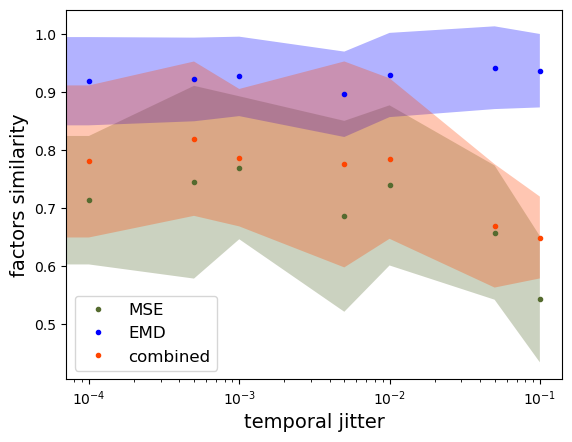

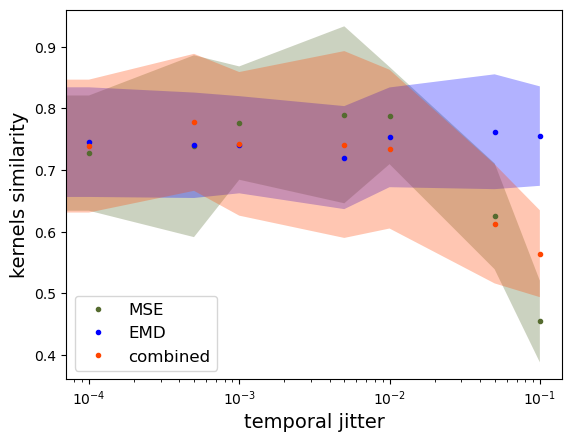

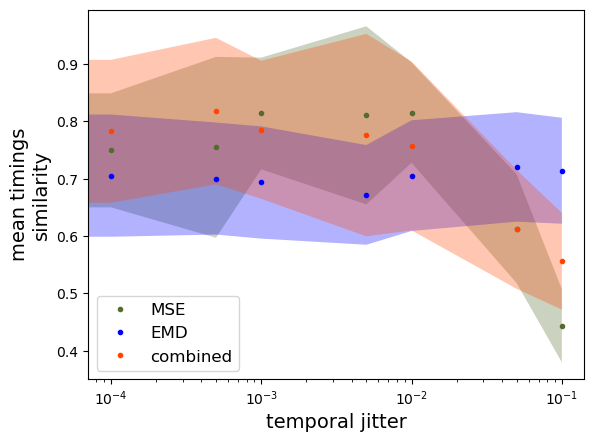

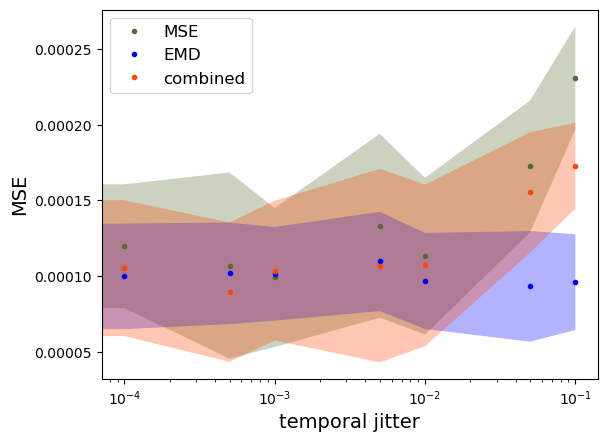

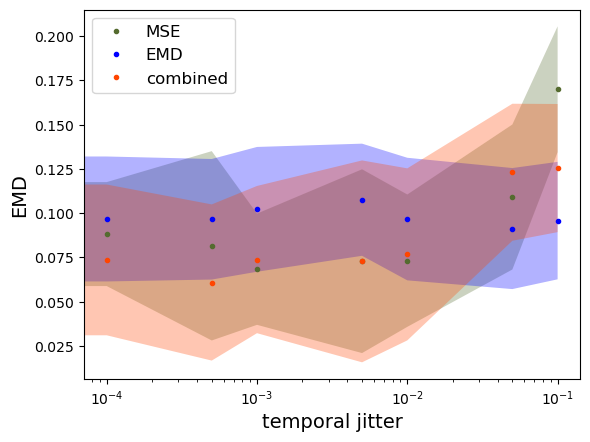

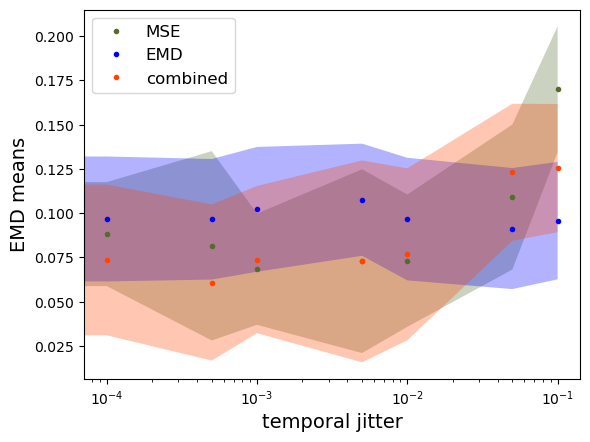

In [9]:
name_metrics = ['factors similarity', 'kernels similarity', 'mean timings\nsimilarity', 'MSE', 'EMD', 'EMD means']
name_methods = ['MSE', 'EMD', 'combined']
colors = ['darkolivegreen','blue', 'orangered']
xlabel = 'temporal jitter'

results = results_max_cc.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)
        if i<3:
            print(f'for {name_metrics[i]} with AE trained with {name_methods[m]}')
            val_max = max(results[m,:,:,i].mean(axis=0))
            ind_max = np.argmax(results[m,:,:,i].mean(axis=0))
            print(f'{val_max} is the max at lambda = {lambdaz[ind_max]}')

## Hyperparameter tuning: optimal lambda for cross correlation

In [10]:
training_parameters.penalty_type = 'cc'
results_cc, lambdaz = performance_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device = device)

../results/2024_12_10_performance_as_a_function_of_lambda_100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_cc_True_(4, 100, 51)_1000_0.001_0.0005_None_0_ignore_1_0_0.1_20


for factors similarity with AE trained with MSE
0.7460848689079285 is the max at lambda = 0.0005
for factors similarity with AE trained with EMD
0.9277880787849426 is the max at lambda = 0.005
for factors similarity with AE trained with combined
0.8149002194404602 is the max at lambda = 0.05
for kernels similarity with AE trained with MSE
0.7453421950340271 is the max at lambda = 0.0005
for kernels similarity with AE trained with EMD
0.7489062547683716 is the max at lambda = 0.005
for kernels similarity with AE trained with combined
0.7705378532409668 is the max at lambda = 0.05
for mean timings
similarity with AE trained with MSE
0.7798774838447571 is the max at lambda = 0.0005
for mean timings
similarity with AE trained with EMD
0.7059246301651001 is the max at lambda = 0.005
for mean timings
similarity with AE trained with combined
0.8110908269882202 is the max at lambda = 0.05


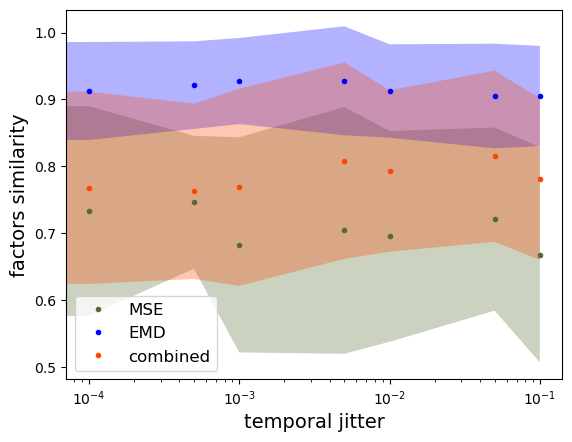

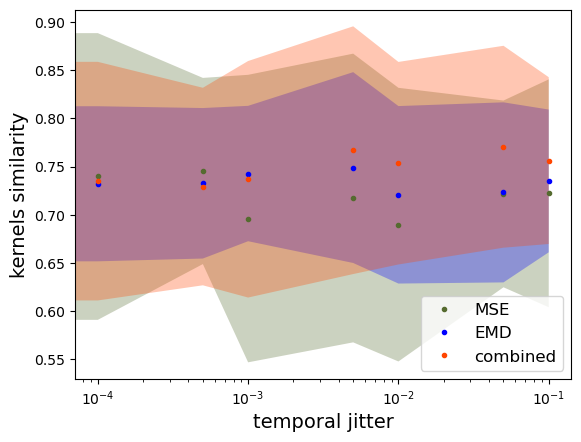

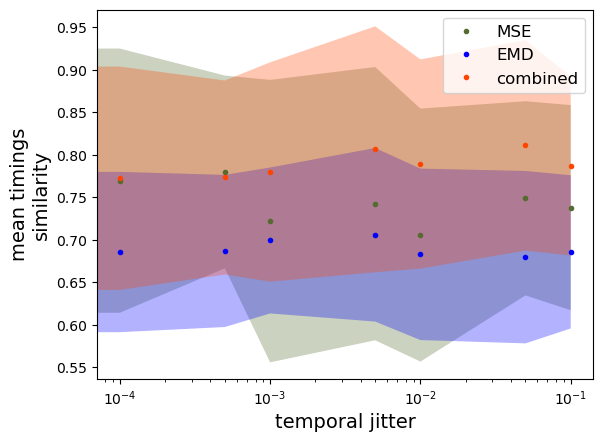

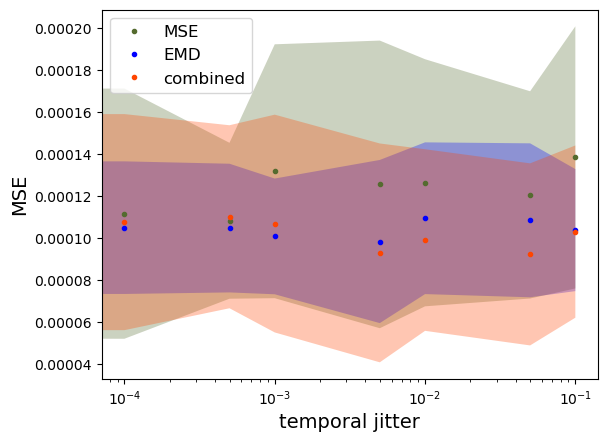

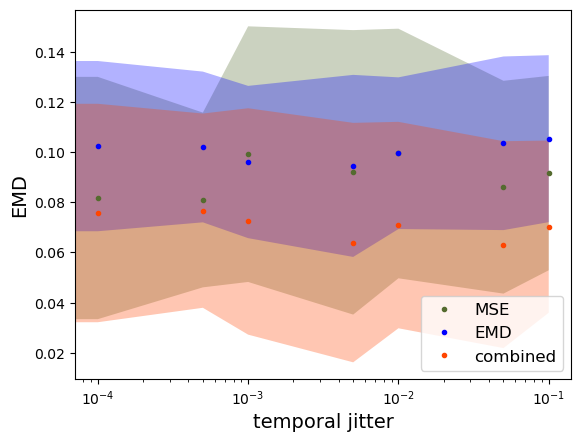

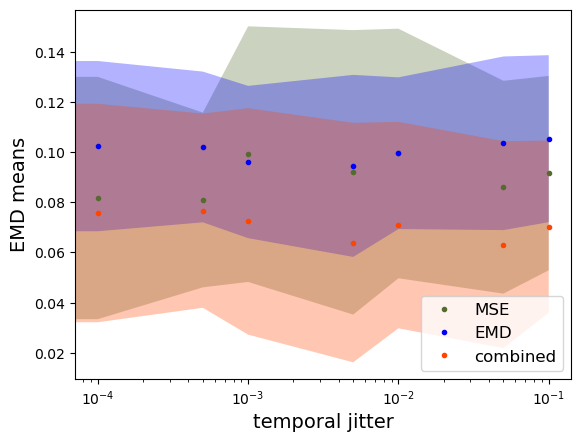

In [11]:
results = results_cc.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)
        if i<3:
            print(f'for {name_metrics[i]} with AE trained with {name_methods[m]}')
            val_max = max(results[m,:,:,i].mean(axis=0))
            ind_max = np.argmax(results[m,:,:,i].mean(axis=0))
            print(f'{val_max} is the max at lambda = {lambdaz[ind_max]}')

## Hyperparameter tuning: optimal lambda for smoothed orthogonality

In [12]:
training_parameters.penalty_type = 'smoothed_orthogonality'
training_parameters.smoothwind = 40
results_smoothed_ortho, lambdaz = performance_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device = device)

../results/2024_12_10_performance_as_a_function_of_lambda_100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_smoothed_orthogonality_True_(4, 100, 51)_1000_0.001_0.0005_None_40_ignore_1_0_0.1_20


for factors similarity with AE trained with MSE
0.8435263633728027 is the max at lambda = 0.005
for factors similarity with AE trained with EMD
0.9364177584648132 is the max at lambda = 0.01
for factors similarity with AE trained with combined
0.7931746244430542 is the max at lambda = 0.05
for kernels similarity with AE trained with MSE
0.8563350439071655 is the max at lambda = 0.005
for kernels similarity with AE trained with EMD
0.747207760810852 is the max at lambda = 0.01
for kernels similarity with AE trained with combined
0.7570144534111023 is the max at lambda = 0.005
for mean timings
similarity with AE trained with MSE
0.8861299753189087 is the max at lambda = 0.005
for mean timings
similarity with AE trained with EMD
0.7164603471755981 is the max at lambda = 0.01
for mean timings
similarity with AE trained with combined
0.8047119975090027 is the max at lambda = 0.005


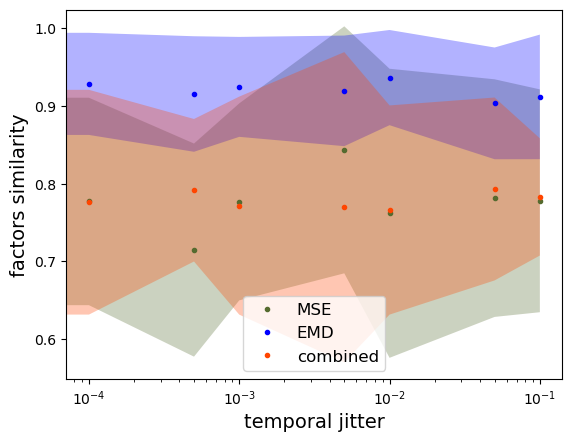

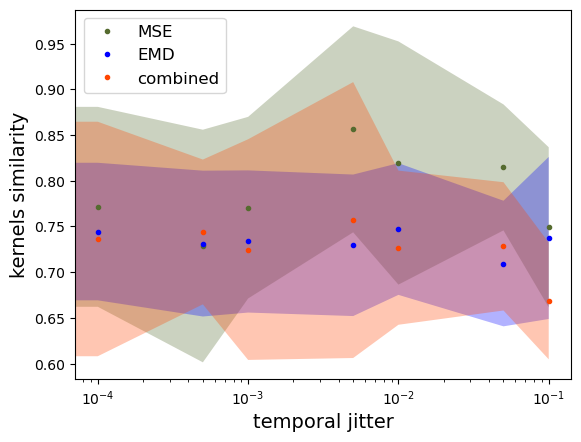

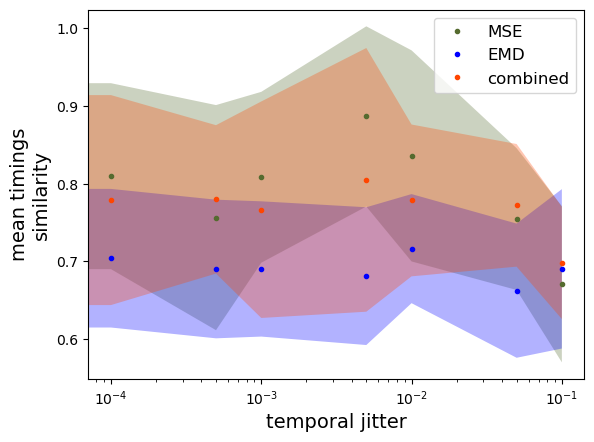

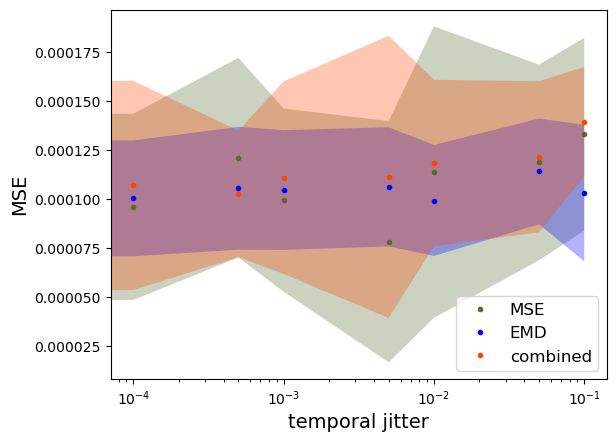

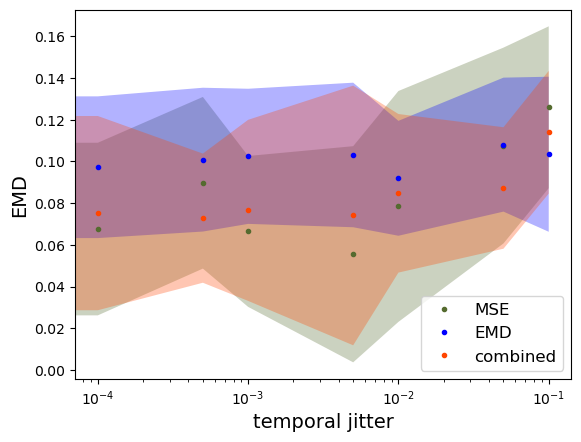

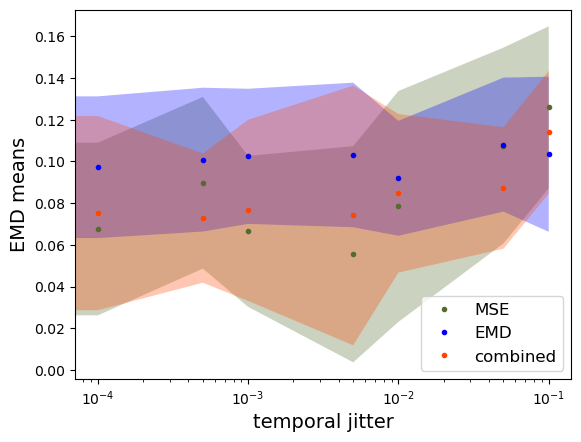

In [13]:
results = results_smoothed_ortho.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)
        if i<3:
            print(f'for {name_metrics[i]} with AE trained with {name_methods[m]}')
            val_max = max(results[m,:,:,i].mean(axis=0))
            ind_max = np.argmax(results[m,:,:,i].mean(axis=0))
            print(f'{val_max} is the max at lambda = {lambdaz[ind_max]}')

## Hyperparameter tuning: optimal lambda for kernels' orthogonality

In [14]:
training_parameters.penalty_type = 'kernels_orthogonality'
results_kernels_ortho, lambdaz = performance_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device = device)

../results/2024_12_10_performance_as_a_function_of_lambda_100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_kernels_orthogonality_True_(4, 100, 51)_1000_0.001_0.0005_None_40_ignore_1_0_0.1_20


for factors similarity with AE trained with MSE
0.7380448579788208 is the max at lambda = 0
for factors similarity with AE trained with EMD
0.9324184656143188 is the max at lambda = 0
for factors similarity with AE trained with combined
0.8886335492134094 is the max at lambda = 0.0005
for kernels similarity with AE trained with MSE
0.869339108467102 is the max at lambda = 0.0001
for kernels similarity with AE trained with EMD
0.7504472136497498 is the max at lambda = 0
for kernels similarity with AE trained with combined
0.7755842208862305 is the max at lambda = 0.0005
for mean timings
similarity with AE trained with MSE
0.8422101736068726 is the max at lambda = 0.0001
for mean timings
similarity with AE trained with EMD
0.713266909122467 is the max at lambda = 0
for mean timings
similarity with AE trained with combined
0.8502429723739624 is the max at lambda = 0.0005


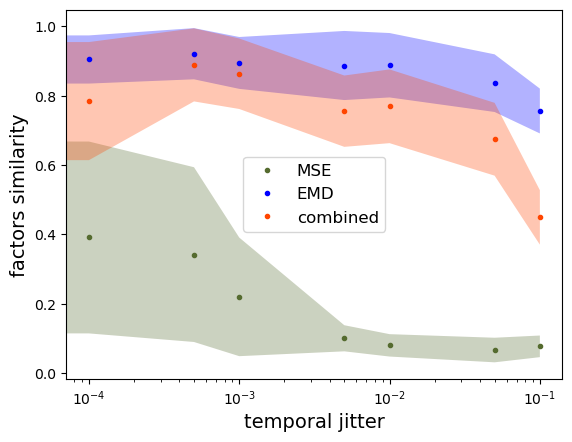

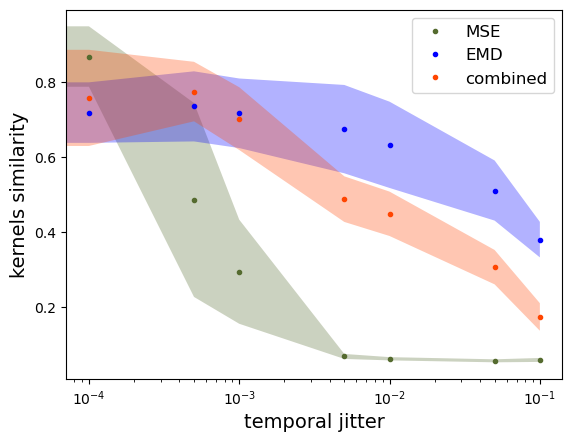

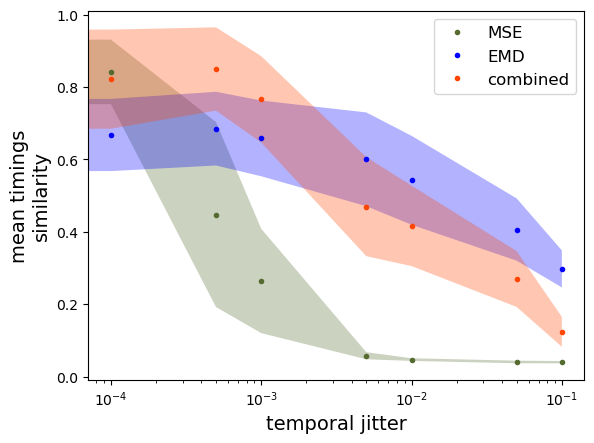

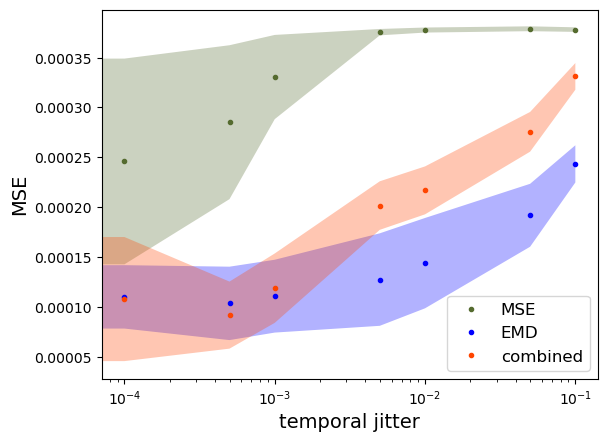

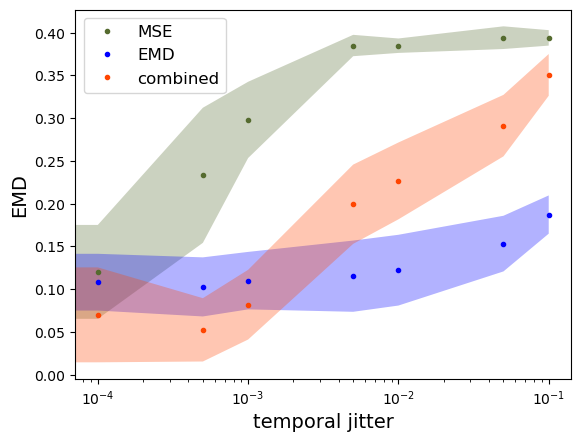

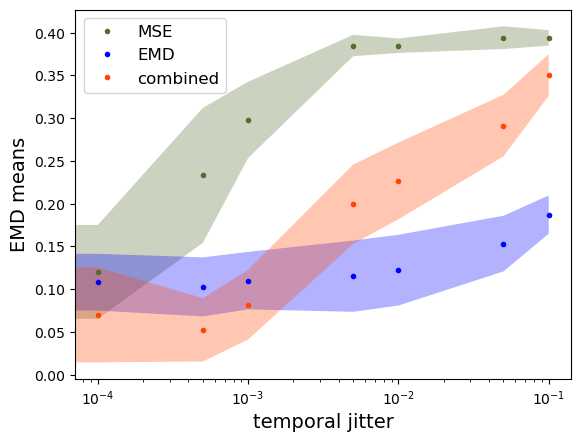

In [15]:
results = results_kernels_ortho.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)
        if i<3:
            print(f'for {name_metrics[i]} with AE trained with {name_methods[m]}')
            val_max = max(results[m,:,:,i].mean(axis=0))
            ind_max = np.argmax(results[m,:,:,i].mean(axis=0))
            print(f'{val_max} is the max at lambda = {lambdaz[ind_max]}')

## Hyperparameter tuning: optimal lambda for sparsity

In [16]:
training_parameters.penalty_type = 'sparsity'
results_sparsity, lambdaz = performance_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device = device)

../results/2024_12_10_performance_as_a_function_of_lambda_100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_sparsity_True_(4, 100, 51)_1000_0.001_0.0005_None_40_ignore_1_0_0.1_20


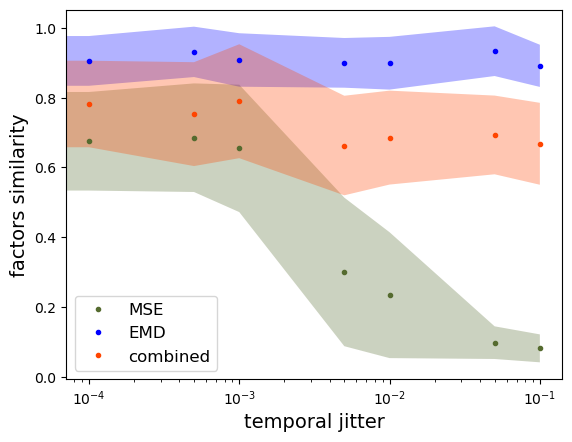

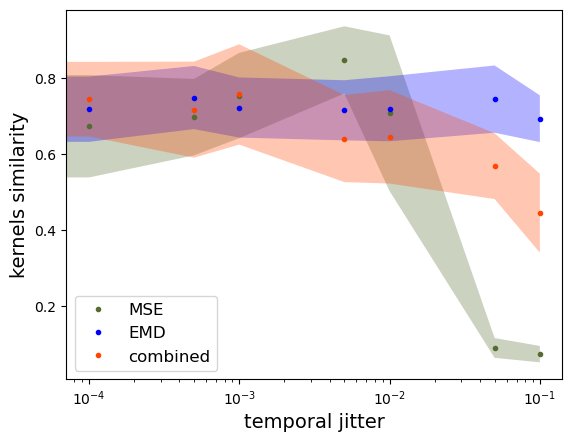

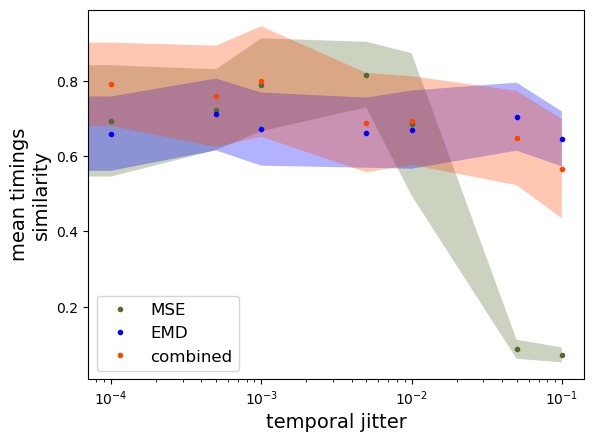

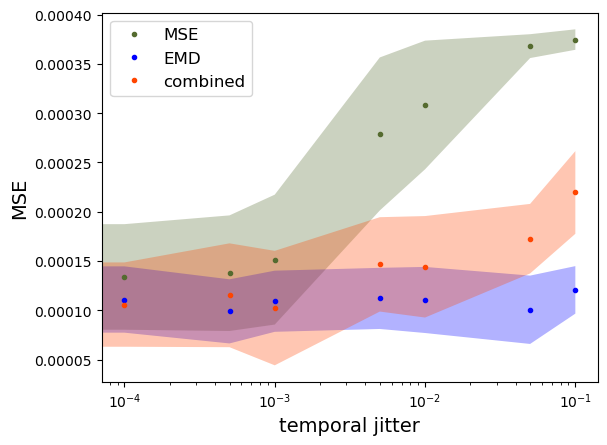

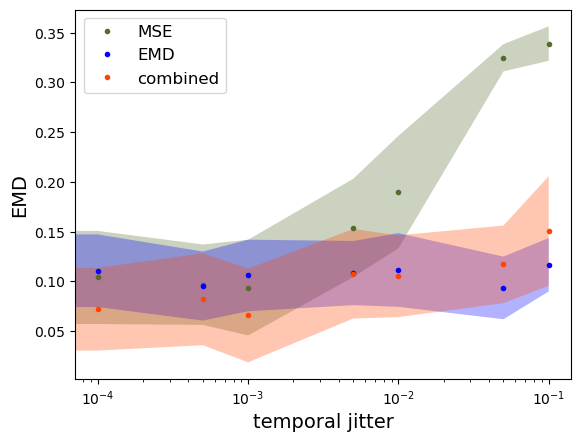

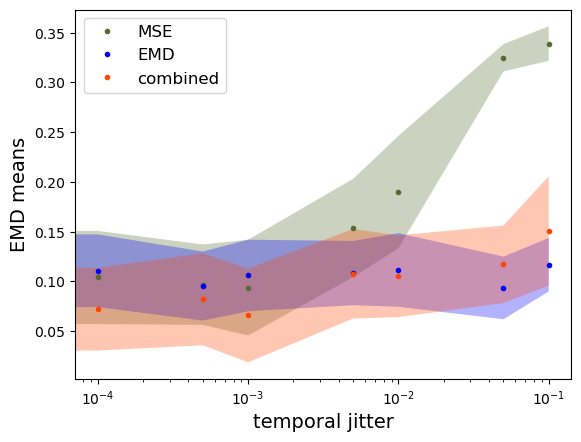

In [17]:
results = results_sparsity.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)

In [18]:
def plot_results_std(ax, results, coefs, xlabel, ylabel, legend, color, ymax=None, ymin=None, do_legend=False, logplot=False, quantile=False):
     
    mean_, std_ = results.mean(axis=0), results.std(axis=0)
    
    if quantile: 
        q5 = results.quantile(.05,axis=0)
        q95 = results.quantile(.95,axis=0)

    if quantile:
        bottom_ = q5
    elif ymin is not None:
        bottom_ = np.maximum(mean_ - std_, ymin*np.ones([len(mean_)]))
    else:
        bottom_ = mean_ - std_
        
    if quantile:
        top_ = q95
    elif ymax is not None:
        top_= np.minimum(mean_ + std_, ymax*np.ones([len(mean_)]))
    else:
        top_ = mean_ + std_

    if logplot:
        ax.semilogx(coefs, mean_, '.',color=color, label=legend)
    else:
        ax.plot(coefs, mean_, '.',color=color, label=legend)
    ax.fill_between(coefs, bottom_, top_, facecolor=color, edgecolor=None, alpha=.3)

    ax.set_ylim(ymin,ymax)
    
    if xlabel: 
        ax.set_xlabel(xlabel, fontsize=14)
    else: 
        ax.set_xticks([])
    if ylabel: 
        ax.set_ylabel(ylabel, fontsize=14)
    else: 
        ax.set_yticks([])
    if do_legend: 
        ax.legend(fontsize=12);

    return ax

In [19]:
lambdaz[0] = .00001

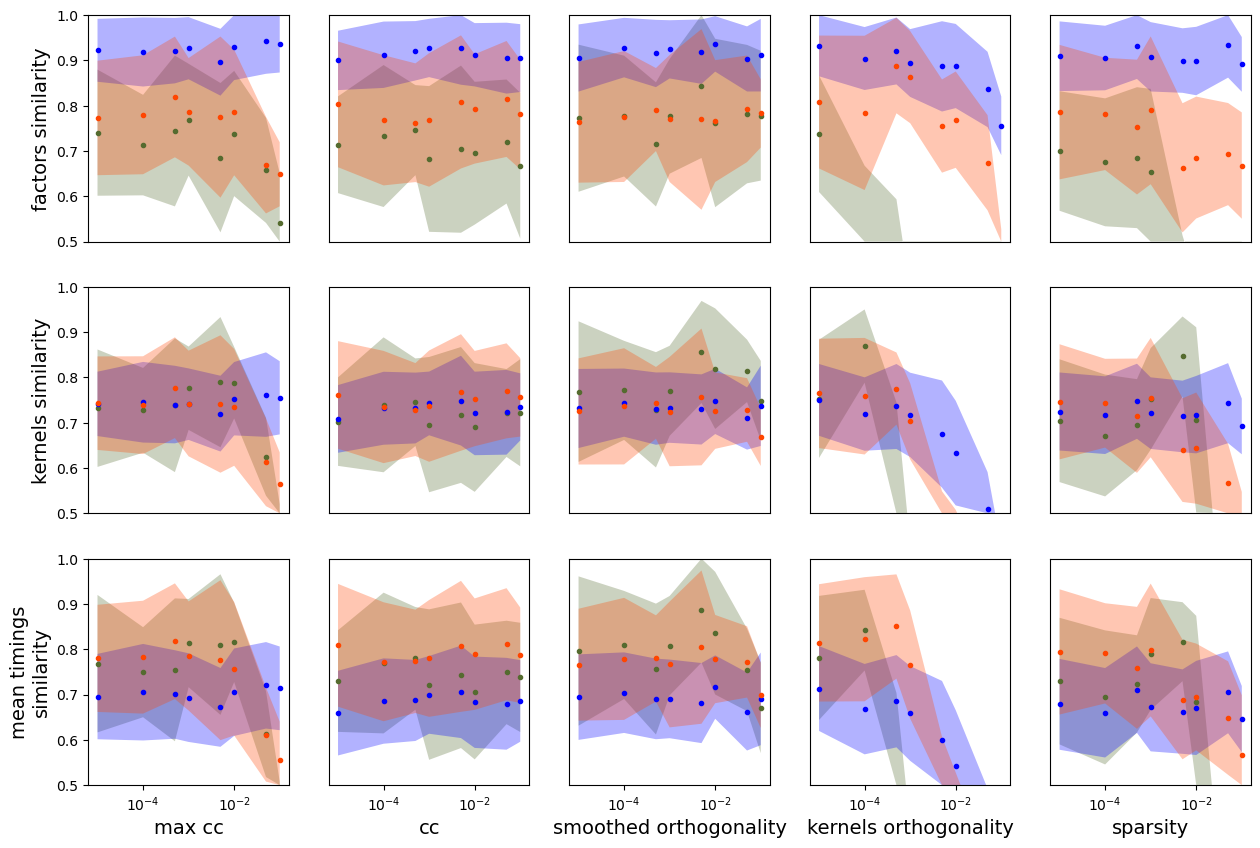

In [20]:
results_all = [results_max_cc, results_cc, results_smoothed_ortho, results_kernels_ortho, results_sparsity]
fig, ax = plt.subplots(3,5, figsize = (15,10))

name_metrics = ['factors similarity', 'kernels similarity', 'mean timings\nsimilarity']
xlabels = ['max cc', 'cc', 'smoothed orthogonality', 'kernels orthogonality', 'sparsity']

for ind_r, regu in enumerate(xlabels):
    results = results_all[ind_r]
    for ind_m, measure in enumerate(name_metrics):
        for ind_l, loss in enumerate(name_methods):
            if ind_m!=2: 
                xlabel = None
            else:
                xlabel = regu
            if ind_r==0: 
                ylabel = measure
            else:
                ylabel = None
            if ind_m == 0:
                ymax, ymin = 1,.5
            else:
                ymax,ymin = 1,.5
            if ind_m==2 and ind_r==0:
                do_legend = True
            else:
                do_legend = False
            ax[ind_m,ind_r] = plot_results_std(ax[ind_m,ind_r],results[ind_l,:,:,ind_m],lambdaz,xlabel,ylabel,loss,colors[ind_l],logplot = True,ymax=ymax,ymin=ymin)

## SeqNMF

In [21]:
from seqnmf import seqnmf
from wassa.wassa import WassA
from wassa.wassa_metrics import get_similarity

def performance_seqnmf_as_a_function_of_lambda(world_parameters, training_parameters, date, lambdaz, N_iter = 5, seeds = None, device='cpu'):
    
    results = torch.zeros([1,N_iter,len(lambdaz),6])
    if seeds is not None:
        assert seeds.size(0)==N_iter
    else:
        seeds = torch.randint(1000,[N_iter])
    
    params_mse = training_parameters()
    params_emd = training_parameters()
    params_emd.loss_type = 'emd'
    file_name = f'../results/{date}_performance_seqnmf_as_a_function_of_lambda{world_parameters().get_parameters()}_{params_emd.get_parameters()}_{lambdaz[0]}_{lambdaz[-1]}'
    print(file_name)
    
    if os.path.isfile(file_name):
        results, lambdaz = torch.load(file_name, map_location='cpu')
    else:
        pbar = tqdm(total=len(lambdaz)*N_iter)
        for i in range(N_iter):
            world_parameters.seed = seeds[i]
            for ind_f, lambda_ in enumerate(lambdaz):
                sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters,verbose = False,device=device)
                path_seqnmf_ = f'../results/{date}_seqnmf_{world_parameters().get_parameters()}_{lambda_}'
                if os.path.isfile(path_seqnmf_):
                    W, H, cost, loadings, power = torch.load(path_seqnmf_)
                else:
                    seqnmf_input = torch.cat([trainset_input[i] for i in range(trainset_input.shape[0])],dim=-1).to('cpu')
                    W, H, cost, loadings, power = seqnmf(seqnmf_input, K=world_parameters.N_SMs, L=world_parameters.N_delays, Lambda=lambda_, max_iter=1000)
                    torch.save([W, H, cost, loadings, power],path_seqnmf_)

                learnt_kernels = WassA(sm.SMs.shape,weight_init=torch.tensor(W.swapaxes(0,1),dtype=torch.float32),device=device)
                if np.isnan(W).sum()==0:
                    results[0,i,ind_f,0], results[0,i,ind_f,1], results[0,i,ind_f,2], results[0,i,ind_f,3], results[0,i,ind_f,4], results[0,i,ind_f,5] = get_similarity(sm,learnt_kernels,testset_input,device=device)
                
                pbar.update(1)

        pbar.close()
        torch.save([results, lambdaz], file_name)
    return results, lambdaz

In [22]:
results, lambdaz = performance_seqnmf_as_a_function_of_lambda(dataset_parameters, training_parameters, date, lambdaz, N_iter = N_iter, seeds = seeds, device='cpu')

../results/2024_12_10_performance_seqnmf_as_a_function_of_lambda100_51_4_255_100_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_sparsity_True_(4, 100, 51)_1000_0.001_0.0005_None_40_ignore_1_1e-05_0.1


  2%|███▊                                                                                                                                                     | 4/160 [00:00<00:33,  4.60it/s]

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
pen_types = ['max_cc', 'cc', 'smoothed_orthogonality', 'kernels_orthogonality']

results = results.cpu()
fig, ax = plt.subplots(3,4, figsize = (20,20))
for i in range(3):
    for p, pen_type in enumerate(pen_types):
        for m in range(len(name_methods)):
            lambdaz = lambdaz_both[lambdaz_ind[p]]
            ax[i,p] = plot_results_std(ax[i,p],results[m,:,p,:,i],lambdaz,xlabel,name_metrics[i],name_methods[m]+pen_type,colors[m], logplot=False)